Corpus-level descriptives for MAG and CSET fields; comparison between the two.

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline

In [2]:
from functools import partial

import pandas as pd
import pandas_gbq
import seaborn as sns
from matplotlib import pyplot as plt

pandas_gbq.context.project = 'gcp-cset-projects'
pandas_gbq.context.dialect = 'standard'

sns.set_theme(style="whitegrid")

query = partial(pd.read_gbq, project_id='gcp-cset-projects')

STEM = ("Biology", "Chemistry", "Computer science", "Engineering", "Environmental science", "Geology", "Materials science", "Mathematics", "Physics")

In [9]:
sample = pd.read_gbq("select merged_id, text from field_model_replication.en_sample", 
                     project_id='gcp-cset-projects', 
                     use_bqstorage_api=True, 
                     progress_bar_type='tqdm')

Downloading: 100%|██████████| 2689349/2689349 [00:48<00:00, 55336.99rows/s]


In [10]:
# sample.to_parquet('en_sample.parquet')

In [14]:
meta = pd.read_pickle("../../assets/fields/fos.pkl.gz")
l0 = meta.loc[meta.level == 0, 'display_name'].values
cs_l1 = """\
Distributed computing
Software engineering
Knowledge management
Human–computer interaction
Data mining
Simulation
Telecommunications
Natural language processing
Computer graphics (images)
Internet privacy
Computer hardware
Artificial intelligence
Database
Library science
Theoretical computer science
Computer engineering
Parallel computing
Computer network
Embedded system
Speech recognition
Data science
Multimedia
Information retrieval
Programming language
Real-time computing
World Wide Web
Computational science
Pattern recognition
Computer vision
Computer architecture
Machine learning
Computer security
Algorithm
Operating system""".split('\n')

In [63]:
from fos.model import FieldModel
field_model = FieldModel("en")
subsample = sample.sample(n=100_000, random_state=20220324)

In [64]:
from tqdm import tqdm
fields = []
for text in tqdm(subsample['text'].values):
    vector = field_model.embed(text)
    sim = field_model.score(vector)
    fields.append(sim.average())

100%|██████████| 100000/100000 [31:33<00:00, 52.81it/s]


In [65]:
def to_names(fields):
    return {meta.loc[str(k), 'display_name']: v for k, v in zip(field_model.index, fields)}

def ordered(fields):
    return dict(sorted(fields.items(), key=lambda x: x[1], reverse=True))

def keep_l0(fields):
    l0_names = meta.loc[meta['level'] == 0, 'display_name'].values
    return {k: v for k, v in fields.items() if k in l0_names}

def keep_l1(fields):
    l1_names = meta.loc[meta['level'] == 1, 'display_name'].values
    return {k: v for k, v in fields.items() if k in l1_names}

named_fields = [ordered(to_names(x)) for x in fields]
l0 = [keep_l0(x) for x in named_fields]
l1 = [keep_l1(x) for x in named_fields]
top_l0 = [list(x.items())[0][0] for x in l0]
top_l1 = [list(x.items())[0][0] for x in l1]

In [66]:
top_cs = [x for x in top_l1 if x in cs_l1]

In [76]:
STEM = ("Biology", "Chemistry", "Computer science", "Engineering", "Environmental science", "Geology",
        "Materials science", "Mathematics", "Physics", 'Medicine')

In [77]:
l0n = pd.DataFrame(pd.DataFrame(top_l0).value_counts())
l0n.columns = ['n']
l0n.reset_index(inplace=True)
l0n.columns = ['field', 'n']
l0n = l0n.loc[l0n['field'].isin(STEM)].copy()
l0n['prop'] = l0n['n'] / l0n['n'].sum()
l0n.to_clipboard(index=False)
l0n

,field,n,prop
0,Biology,18246,0.230705
1,Medicine,16520,0.208881
2,Computer science,8859,0.112014
3,Chemistry,8540,0.107981
4,Physics,7529,0.095198
5,Materials science,5130,0.064864
6,Mathematics,5125,0.064801
7,Geology,4547,0.057493
11,Engineering,2733,0.034556
16,Environmental science,1859,0.023505


Here's counts for all available MAG/v1 field scores that aren't imputed.

In [78]:
%%bigquery mag_counts --project gcp-cset-projects
select
  field.name as name,
  count(*) as n
from fields_of_study.top_fields, unnest(top_fields.fields) field
-- Add is_imputed flag missing from top_fields table
inner join fields_of_study.field_scores using(merged_id)
where
  level = 0
  and is_imputed is false
group by name
order by n desc

Downloading: 100%|██████████| 19/19 [00:01<00:00, 15.88rows/s]


In [79]:
mag_counts = mag_counts.loc[mag_counts['name'].isin(STEM)].copy()
mag_counts['prop'] = mag_counts['n'] / mag_counts['n'].sum()
mag_counts

,name,n,prop
0,Medicine,34230645,0.267948
1,Computer science,22277240,0.174380
2,Chemistry,18327064,0.143459
3,Materials science,15757342,0.123344
5,Biology,10512113,0.082286
8,Physics,7567855,0.059239
11,Environmental science,5906748,0.046236
13,Mathematics,5676774,0.044436
15,Geology,4007948,0.031373
16,Engineering,3487256,0.027297


In [80]:
pd.merge(mag_counts, l0n, left_on='name', right_on='field', suffixes=('_mag', '_cset')).to_clipboard(index=False)

Next we do the same thing, but for L1 children of CS.

In [95]:
%%bigquery mag_cs_counts --project gcp-cset-projects
select
    field.name as name,
    count(*) as n
from fields_of_study.top_fields, unnest(top_fields.fields) field
-- Add is_imputed flag missing from top_fields table
inner join fields_of_study.field_scores using(merged_id)
where
    level = 1
    and is_imputed is false
    and field.id in (
        select child_field_id
        from fields_of_study.field_children
        where field_id = 41008148 -- CS
)
group by name
order by n desc

Downloading: 100%|██████████| 34/34 [00:01<00:00, 24.05rows/s]


In [120]:
agg = {
    "AI/ML": "Artificial intelligence	Data mining	Pattern recognition	Machine learning	Data science".split('\t'),
    "Computer engineering": "Computer engineering	Computer architecture	Computer hardware".split('\t'),
    "Networks": "Computer network	World Wide Web".split('\t'),
    'IR & Knowledge management': "Knowledge management	Database	Information retrieval	Library science".split('\t'),
    'Software': "Software engineering	Programming language	Operating system	Embedded system".split('\t'),
    'Security & Privacy': "Computer security	Internet privacy".split('\t'),
    'High Performace Computing': "Real-time computing	Distributed computing	Parallel computing".split('\t'),
}
def collapse_cs(top_fields, agg, drop=True):
    output = []
    for label in top_fields:
        result = label
        for cluster, members in agg.items():
            if label in members:
                result = cluster
                break
        if drop and result not in agg.keys():
            continue
        output.append(result)
    return output

short_cs = collapse_cs(top_cs, agg, drop=True)

short_csn = pd.DataFrame(pd.DataFrame(short_cs).value_counts())

csn = pd.DataFrame(pd.DataFrame(top_cs).value_counts())

csn = short_csn
csn.columns = ['n']
csn.reset_index(inplace=True)
csn.columns = ['field', 'n']
csn['prop'] = csn['n'] / csn['n'].sum()
csn

,field,n,prop
0,AI/ML,2113,0.337540
1,Networks,1068,0.170607
2,IR & Knowledge management,1060,0.169329
3,Security & Privacy,606,0.096805
4,High Performace Computing,587,0.093770
5,Software,543,0.086741
6,Computer engineering,283,0.045208


In [121]:
short_mag_cs = list(zip(collapse_cs(mag_cs_counts['name'].values, agg, drop=True), mag_cs_counts['n'].values))
short_mag_cs = pd.DataFrame(short_mag_cs).groupby(0, as_index=False)[1].sum()
short_mag_cs.columns = ['field', 'n']
short_mag_cs['prop'] = short_mag_cs['n'] / short_mag_cs['n'].sum()
short_mag_cs

,field,n,prop
0,AI/ML,3299400,0.232669
1,Computer engineering,942448,0.066460
2,High Performace Computing,1229803,0.086724
3,IR & Knowledge management,4516363,0.318487
4,Networks,1665476,0.117447
5,Security & Privacy,882446,0.062229
6,Software,1644744,0.115985


In [123]:
cs_comp = pd.merge(short_mag_cs, csn, on='field', how='inner', suffixes=('_mag', '_cset'))
cs_comp = cs_comp.loc[cs_comp['field'].isin(agg.keys())]
cs_comp['prop_mag'] = cs_comp['n_mag'] /  cs_comp['n_mag'].sum()
cs_comp['prop_cset'] = cs_comp['n_cset'] /  cs_comp['n_cset'].sum()
cs_comp

,field,n_mag,prop_mag,n_cset,prop_cset
0,AI/ML,3299400,0.232669,2113,0.337540
1,Computer engineering,942448,0.066460,283,0.045208
2,High Performace Computing,1229803,0.086724,587,0.093770
3,IR & Knowledge management,4516363,0.318487,1060,0.169329
4,Networks,1665476,0.117447,1068,0.170607
5,Security & Privacy,882446,0.062229,606,0.096805
6,Software,1644744,0.115985,543,0.086741


In [124]:
cs_export = cs_comp[['field', 'prop_mag', 'prop_cset']]
cs_export.columns = ['Field', 'MAG', 'CSET']
cs_export.to_clipboard(index=False)

In [94]:
mag_counts

,name,n,prop
0,Medicine,34230645,0.267948
1,Computer science,22277240,0.174380
2,Chemistry,18327064,0.143459
3,Materials science,15757342,0.123344
5,Biology,10512113,0.082286
8,Physics,7567855,0.059239
11,Environmental science,5906748,0.046236
13,Mathematics,5676774,0.044436
15,Geology,4007948,0.031373
16,Engineering,3487256,0.027297


In [138]:
cs_counts = pd.merge(mag_cs_counts, cset_cs_counts, how='left', on='name', suffixes=('_mag', '_cset'))
cs_counts = cs_counts.sort_values(['prop_mag', 'prop_cset'], ascending=False)
cs_counts

,name,n_mag,prop_mag,n_cset,prop_cset
0,Library science,2916299,0.184245,599584,0.038866
1,Algorithm,1317748,0.083252,951620,0.061686
2,Pattern recognition,910968,0.057553,618511,0.040093
3,Computer vision,829875,0.052430,509948,0.033056
4,Computer network,754508,0.047668,831995,0.053931
5,Knowledge management,634517,0.040087,1843618,0.119506
6,World Wide Web,552215,0.034888,277804,0.018008
7,Data science,494252,0.031226,321555,0.020844
8,Human–computer interaction,478545,0.030233,183031,0.011864
9,Data mining,472982,0.029882,370788,0.024035


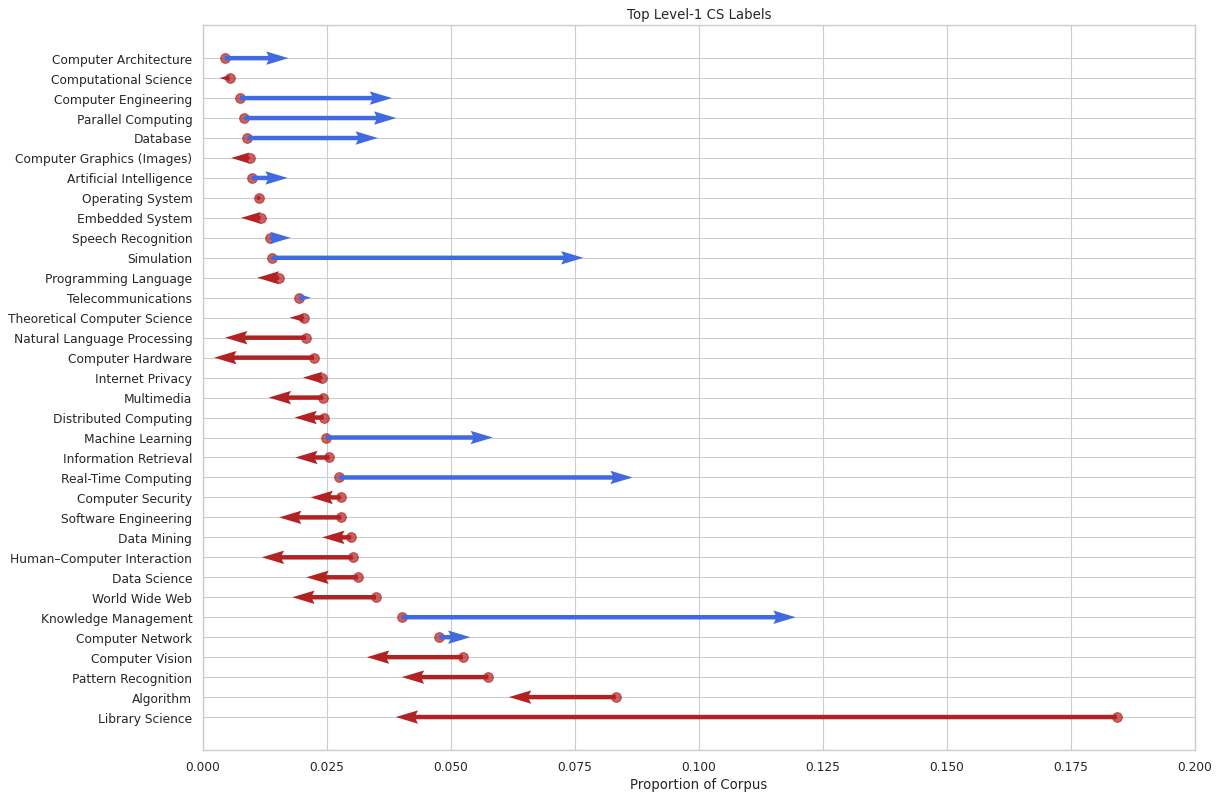

In [139]:
fig, ax = plt.subplots(figsize=(16,12), dpi=80)
ax.hlines(y=cs_counts.index, xmin=11, xmax=26, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=cs_counts.index, x=cs_counts['prop_mag'], s=75, color='firebrick', alpha=0.7)
# ax.scatter(y=cs_counts.index, x=cs_counts['prop_cset'], s=75, color='royalblue', alpha=0.7)
ax.quiver(cs_counts['prop_mag'], cs_counts.index, cs_counts['prop_cset'] - cs_counts['prop_mag'],
          [0] * cs_counts.shape[0], units='x', angles='xy', scale=1, width=0.0009,
          color=cs_counts.apply(lambda row: 'firebrick' if row['prop_mag'] > row['prop_cset'] else 'royalblue', axis=1))

# Title, Label, Ticks and Ylim
ax.set_title('Top Level-1 CS Labels')
ax.set_xlabel('Proportion of Corpus')
ax.set_yticks(cs_counts.index)
ax.set_yticklabels(cs_counts['name'].str.title(), fontdict={'horizontalalignment': 'right'})
ax.set_xlim(0, .2)
plt.savefig('cs_proportion_change.png')
plt.show()

In [163]:
ai = "Artificial intelligence	Data mining	Pattern recognition	Machine learning	Data science".split('\t')
eng = "Computer engineering	Computer architecture	Computer hardware".split('\t')
networks = "Computer network	World Wide Web".split('\t')
ir_kb = "Knowledge management	Database	Information retrieval	Library science".split('\t')
software = "Software engineering	Programming language	Operating system	Embedded system".split('\t')
security = "Computer security	Internet privacy".split('\t')
drop = "Computational science,Telecommunications,Multimedia,Simulation".split(',')

hpc = "Real-time computing	Distributed computing	Parallel computing".split('\t')
cs_counts['short_name'] = cs_counts['name']
cs_counts.loc[cs_counts['name'].isin(ai), 'short_name'] = 'AI'
cs_counts.loc[cs_counts['name'].isin(eng), 'short_name'] = 'Engineering'
cs_counts.loc[cs_counts['name'].isin(networks), 'short_name'] = 'Networks'
cs_counts.loc[cs_counts['name'].isin(ir_kb), 'short_name'] = 'IR & Knowledge Mgmt'
cs_counts.loc[cs_counts['name'].isin(hpc), 'short_name'] = 'HPC'
cs_counts.loc[cs_counts['name'].isin(security), 'short_name'] = 'Security & Privacy'
cs_counts.loc[cs_counts['name'].isin(software), 'short_name'] = 'Software'
short_cs = cs_counts.loc[~cs_counts['name'].isin(drop)].copy()
short_cs = short_cs.groupby('short_name')[['n_mag', 'n_cset']].agg('sum')
short_cs['prop_mag'] = short_cs['n_mag'] / short_cs['n_mag'].sum()
short_cs['prop_cset'] = short_cs['n_cset'] / short_cs['n_cset'].sum()
short_cs = short_cs.sort_values('short_name', ascending=False)
short_cs = short_cs.reset_index()

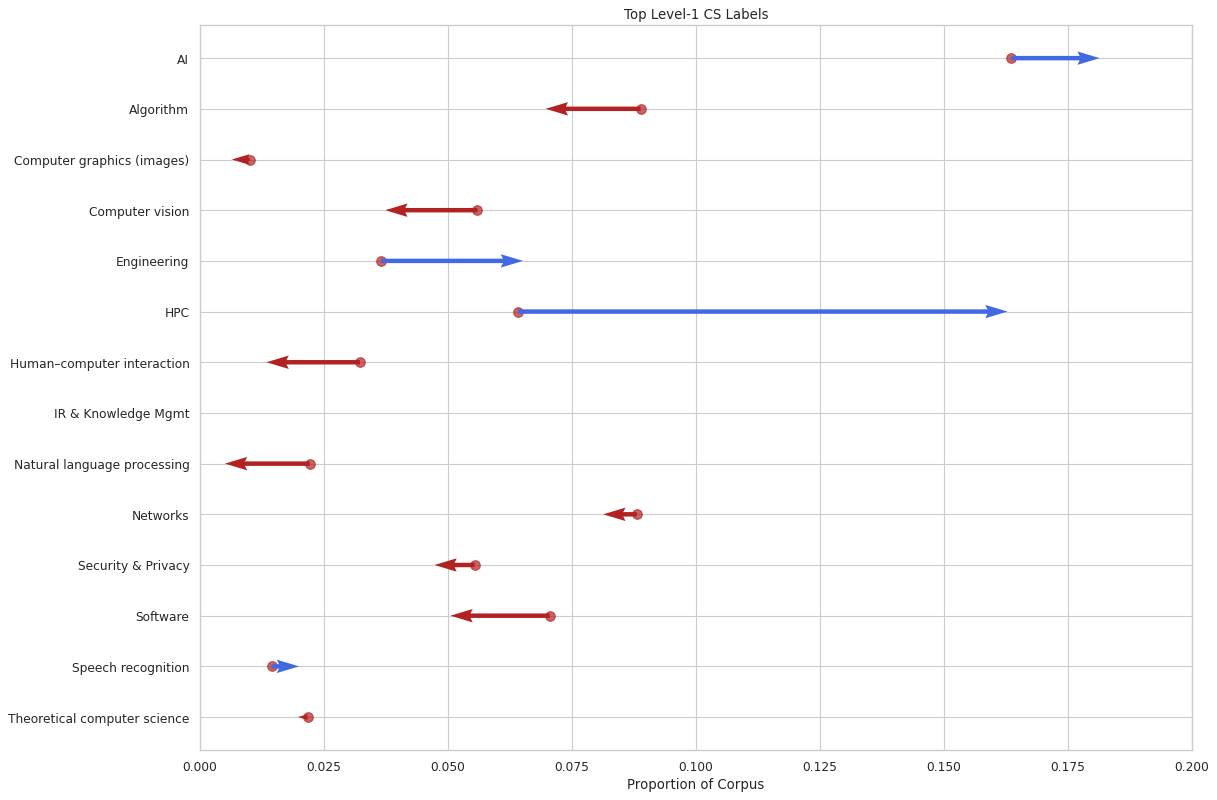

In [164]:
fig, ax = plt.subplots(figsize=(16,12), dpi=80)
ax.hlines(y=short_cs.index, xmin=11, xmax=26, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=short_cs.index, x=short_cs['prop_mag'], s=75, color='firebrick', alpha=0.7)
# ax.scatter(y=short_cs.index, x=short_cs['prop_cset'], s=75, color='royalblue', alpha=0.7)
ax.quiver(short_cs['prop_mag'], short_cs.index, short_cs['prop_cset'] - short_cs['prop_mag'],
          [0] * short_cs.shape[0], units='x', angles='xy', scale=1, width=0.0009,
          color=short_cs.apply(lambda row: 'firebrick' if row['prop_mag'] > row['prop_cset'] else 'royalblue', axis=1))

# Title, Label, Ticks and Ylim
ax.set_title('Top Level-1 CS Labels')
ax.set_xlabel('Proportion of Corpus')
ax.set_yticks(short_cs.index)
ax.set_yticklabels(short_cs['short_name'], fontdict={'horizontalalignment': 'right'})
ax.set_xlim(0, .2)
plt.savefig('short_cs_proportion_change.png')
plt.show()

In [169]:
cs_counts['name'].to_clipboard(index=False)